# 根据蛋白质一级序列预测分类

-数据集来源：https://www.kaggle.com/datasets/shahir/protein-data-set
-基本框架来源：https://github.com/nadimintikrish/protein_lstm

#数据提取与预处理

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt#数据可视化工具

In [ ]:

df_pdb_data_no_seq = pd.read_csv('sampled_file1.无.十万版.csv')
df_pdb_seq = pd.read_csv('sampled_file2.有.十万版.csv')
print("..Read data files..")

..Read data files..


In [3]:
# filtering out only protein structures
df_protein_seq = df_pdb_seq[(df_pdb_seq['macromoleculeType'] == 'Protein')]

In [4]:
# joining two data sets for protein Seq - classification

df_protein_final = df_protein_seq.merge(df_pdb_data_no_seq, on='structureId')

df_protein_seq_final = df_protein_final[['sequence', 'classification']]

df_protein_seq_final.head()

,sequence,classification
0,MRIYSRLFQISSANYARQIMSNQFIKAKESKGLTYQQMAQLLSVNK...,LYASE
1,SMSYTWTGALITPCAAEESKLPINPLSNSLLRHHNMVYATTSRSAS...,TRANSFERASE/TRANSFERASE INHIBITOR
2,SNAPVEGSEEDKSQTGVNRASKGGLIYGNYLHLEKVLNAQELQSET...,OXIDOREDUCTASE
3,AQLVDSMPSASTGSVVVTDDLNYWGGRRIKSKDGATTEPVFEPATG...,OXIDOREDUCTASE
4,GSHMAEISSDIISSDIDQLNPESADLRALAKHLYDSYIKSFPLTKA...,TRANSCRIPTION


In [5]:
df_protein_seq_final = df_protein_seq_final.dropna()
print("filtered data with NA values")

filtered data with NA values


In [6]:
from utilities.EmbeddingEncoder import EmbeddingEncoder

embed_enoder = EmbeddingEncoder()

embed_enoder.find_unique_amino_acids(df_protein_seq_final['sequence'])
print("Unique Amino Acid Set...")

Unique Amino Acid Set...


In [7]:
embed_enoder.create_embed_encoder()
print(embed_enoder.embed_encoder)

{'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23, 'Z': 24, '<PAD>': 0}


In [8]:
from utilities.DataPreProcessor import DataPreProcessor

count_dict = df_protein_seq_final['classification'].value_counts().to_dict()
data_pre_processor = DataPreProcessor(count_dict,embed_enoder,5)

In [9]:
## delete least preferred sequences
data_pre_processor.del_least_preferred()

df_protein_seq_final_for_modeling = \
    df_protein_seq_final[df_protein_seq_final['classification']
        .isin(data_pre_processor.count_dict_keys_as_list())]

df_protein_seq_final_for_modeling = \
    df_protein_seq_final_for_modeling.reset_index(drop=True)
print("final Shape of the DataSet {}".format(df_protein_seq_final_for_modeling.shape))

final Shape of the DataSet (49367, 2)


In [10]:
## only considering sequences of length between 50 and 1200
df_protein_seq_final_for_modeling = \
    df_protein_seq_final_for_modeling[df_protein_seq_final_for_modeling.apply(
        lambda x: len(x['sequence']) <=1200 and len(x['sequence']) >=50 ,axis=1
    )]

In [10]:
print("final Shape of the DataSet {}".format(df_protein_seq_final_for_modeling.shape))

final Shape of the DataSet (49367, 2)


In [11]:
X_sequences = df_protein_seq_final_for_modeling['sequence']
y_label = df_protein_seq_final_for_modeling['classification']

In [12]:
## test process sequences

data_pre_processor.process_seqs_to_embeddings(X_sequences,y_label,1200)
print("Getting Processed Seqs")
print(data_pre_processor.get_x().shape)
print("getting labels")
print(data_pre_processor.get_y().shape)
# print("getting protein categories")
# print(data_pre_processor.get_protein_categoeies())

Getting Processed Seqs
(49367, 1200)
getting labels
(49367, 463)


## LSTM Modeling

In [13]:
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization


In [14]:
from tensorflow.keras.layers import GlobalMaxPooling1D

In [15]:
from keras.regularizers import l2

In [ ]:
embed_vol = 5000
embed_dim = 100
num_features = 25
max_seq_length = 1200
## AAs are supposed to be integer encoded for embedding layer 


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 128)         640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 1200, 128)        0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 1200, 64)          41024     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 600, 64)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 600, 64)          256       
 ormalization)                                                   
                                                        

In [ ]:

model = Sequential()
model.add(Embedding(5000, 128, input_length=1200))  # 增大嵌入维度
model.add(SpatialDropout1D(0.2))  # 降低Dropout比例
# 新增卷积块
model.add(Conv1D(64, 5, activation='relu', padding='same', kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2))
model.add(BatchNormalization())
model.add(Conv1D(128, 5, activation='relu', padding='same', kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2))  # 新增池化层
model.add(BatchNormalization())
model.add(Conv1D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(0.005))) # 新增卷积层
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.005)))  # 增大全连接层维度
model.add(Dropout(0.3))  # 适度Dropout
model.add(Dense(463, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

## Test-Train Split

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data_pre_processor.get_x(), 
    data_pre_processor.get_y(), 
    test_size=0.20, 
    random_state=42
)

In [18]:
# 数据增强：随机截断序列（长度50-1200）
def random_truncate(sequence, max_len=1200):
    if len(sequence) > max_len:
        start = np.random.randint(0, len(sequence)-max_len)
        return sequence[start:start+max_len]
    else:
        return sequence.ljust(max_len, 'X')  # 用'X'填充短序列
    
X_sequences = X_sequences.apply(random_truncate)

In [19]:
print("train data shape is {} and {}".format(X_train.shape,y_train.shape))
print("test data shape is {} and {}".format(X_test.shape,y_test.shape))

train data shape is (39493, 1200) and (39493, 463)
test data shape is (9874, 1200) and (9874, 463)


In [18]:
# from keras.callbacks import TensorBoard

# tensor_board = TensorBoard(log_dir='logs/Graph', histogram_freq=0, write_graph=True, write_images=True)

## Fit the Model (Training with validation split)

In [20]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:

# 早停：当验证损失3轮不下降时终止训练
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 

# 动态学习率：损失停滞时自动降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-3)


Epoch 1/20
247/247 [==============================] - 171s 692ms/step - loss: 1.6339 - accuracy: 0.6908 - val_loss: 2.6044 - val_accuracy: 0.5702 - lr: 1.0000e-05
Epoch 2/20
247/247 [==============================] - 173s 701ms/step - loss: 1.6357 - accuracy: 0.6900 - val_loss: 2.6019 - val_accuracy: 0.5713 - lr: 1.0000e-05
Epoch 3/20
247/247 [==============================] - 169s 685ms/step - loss: 1.6297 - accuracy: 0.6907 - val_loss: 2.6038 - val_accuracy: 0.5715 - lr: 1.0000e-05
Epoch 4/20
247/247 [==============================] - 157s 637ms/step - loss: 1.6286 - accuracy: 0.6932 - val_loss: 2.6005 - val_accuracy: 0.5716 - lr: 1.0000e-05
Epoch 5/20
247/247 [==============================] - 149s 602ms/step - loss: 1.6266 - accuracy: 0.6919 - val_loss: 2.5989 - val_accuracy: 0.5720 - lr: 1.0000e-05
Epoch 6/20
247/247 [==============================] - 148s 600ms/step - loss: 1.6299 - accuracy: 0.6912 - val_loss: 2.6017 - val_accuracy: 0.5727 - lr: 1.0000e-05
Epoch 7/20
247/247 [==

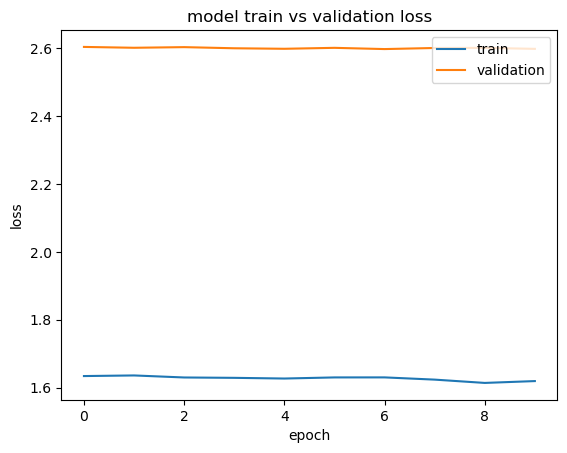

In [25]:
history = model.fit(
    X_train, y_train,
    epochs=20,  # 延长训练轮次
    batch_size=128,  # 增大批次提升稳定性
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]   
)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()